<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/J-TKim/apple_segmentation/blob/main/apple_segemetation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in google Colab</a>
  </td>
</table>

# Calculate the Roundness, and Sphericity (With Pattern Recognition)

## clone from github

In [1]:
!git clone https://github.com/J-TKim/apple_segmentation.git

Cloning into 'apple_segmentation'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 75 (delta 32), reused 30 (delta 8), pack-reused 0
Unpacking objects: 100% (75/75), done.


## 1. Load origin image

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math
from apple_segmentation.calculate import calculate_roundness

# set image path
image_path = '/content/apple_segmentation/data/apple1.png'
img = cv2.imread(image_path)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

## 2. Convert to Gray

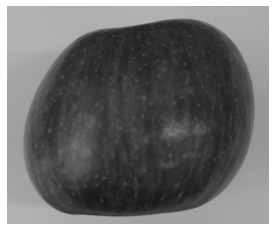

In [3]:
plt.axis("off")
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
plt.show()

## 3. Find Object (with Pattern Recognition)

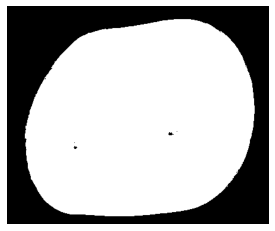

In [4]:
plt.axis("off")
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

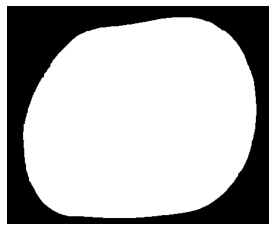

In [6]:
plt.axis("off")
plt.imshow(cv2.cvtColor(sure_bg, cv2.COLOR_BGR2RGB))
plt.show()

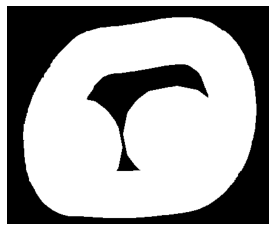

In [7]:
plt.axis("off")
plt.imshow(cv2.cvtColor(unknown, cv2.COLOR_BGR2RGB))
plt.show()

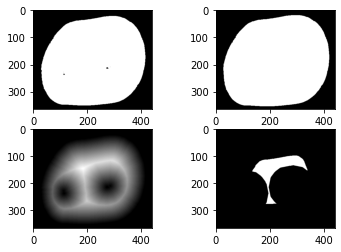

In [8]:
plt.figure()
plt.subplot(221), plt.imshow(opening, cmap='gray')
plt.subplot(222), plt.imshow(sure_bg, cmap='gray')
plt.subplot(223), plt.imshow(dist_transform, cmap='gray')
plt.subplot(224), plt.imshow(sure_fg, cmap='gray')
plt.show()

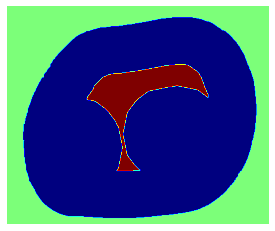

In [9]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

plt.imshow(markers, cmap='jet')
plt.axis('off')
plt.show()

markers :    
>outside == 1   
>line == -1    
>inside == 2   


(<matplotlib.axes._subplots.AxesSubplot at 0x7f6b7d8f7a10>,
 <matplotlib.image.AxesImage at 0x7f6b7d897c50>)

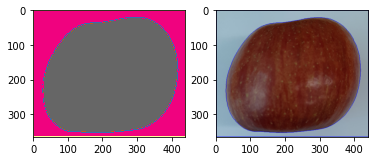

In [10]:
markers = cv2.watershed(img, markers)
img[markers == -1] = [255, 0, 0]

plt.subplot(121), plt.imshow(markers, cmap='Accent')
plt.subplot(122), plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

convert sure_bg to np.uint8 type (to findContours)

In [11]:
sure_bg = sure_bg.astype(np.uint8)

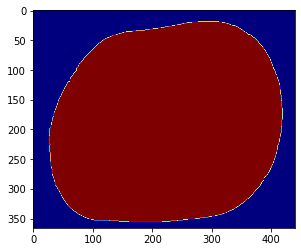

In [12]:
plt.imshow(sure_bg, cmap="jet")

In [13]:
ret, thresh = cv2.threshold(sure_bg, -1, 1, 0)
contours, hierarchy = cv2.findContours(sure_bg, 1, 2)

cnt = contours[0]
M = cv2.moments(cnt)
print(M)

{'m00': 108801.5, 'm10': 24448556.5, 'm01': 20900476.0, 'm20': 6598325934.25, 'm11': 4555639089.541666, 'm02': 4844563751.083333, 'm30': 1976474331832.55, 'm21': 1207987105745.7666, 'm12': 1035570041693.9333, 'm03': 1246656066890.3, 'mu20': 1104542163.4959917, 'mu11': -140862965.69556904, 'mu02': 829638432.713862, 'mu30': -2620325783.883301, 'mu21': 3772453577.9351196, 'mu12': 1077093355.9538574, 'mu03': -2714251655.0742188, 'nu20': 0.09330663623215708, 'nu11': -0.011899454754301897, 'nu02': 0.07008403481894801, 'nu30': -0.0006710704001758477, 'nu21': 0.0009661325121328792, 'nu12': 0.00027584565012962254, 'nu03': -0.000695124993827765}


In [14]:
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])

In [15]:
area = cv2.contourArea(cnt)

In [16]:
perimeter = cv2.arcLength(cnt, True)

In [17]:
epsilon = 0.01 * cv2.arcLength(cnt, True)
approx = cv2.approxPolyDP(cnt, epsilon, True)

In [18]:
hull = cv2.convexHull(cnt)

In [19]:
k = cv2.isContourConvex(cnt)

## 4. Measure object's width, height (depth), and Circumscribed circle(sphere)


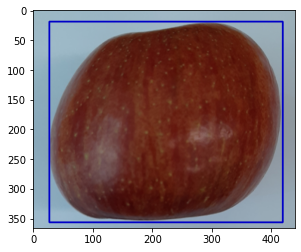

In [20]:
img = cv2.imread(image_path)

idx =0 
for cnt in contours:
    idx += 1
    x,y,w,h = cv2.boundingRect(cnt)
    roi=img[y:y+h,x:x+w]
    cv2.imwrite(str(idx) + '.jpg', roi)
    cv2.rectangle(img,(x,y),(x+w,y+h),(200,0,0),2)

plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB), "Accent")
plt.show()

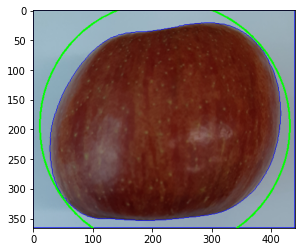

In [21]:
img = cv2.imread(image_path)
img[markers == -1] = [255, 0, 0]

(x, y), radius = cv2.minEnclosingCircle(cnt)
center = (int(x), int(y))
radius = int(radius)
img = cv2.circle(img, center, radius, (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB), "Accent")
plt.show()

## 5. Calculate the Roundness, and Sphericity

### Roundness
$$ Roundness = \frac{A_p}{A_c} \times 100 = \frac{A_p}{\frac{\pi}{4}L^{2}} \times 100
\\ \text{}
\\ Roundness = \text{원형률} (\%)\\
A_p = \text{생물체를 평면에 자연스럽게 놓았을 때의 투영면적} (m^2)\\
A_c = \text{생물체에 최소로 외접하는 원의 면적} (m^2)\\
L = \text{생물체의 최대치수 (길이)} (m)$$

apple1.png Roundness (Frontal photo)

In [22]:
A_p = area
A_c = radius ** 2 * math.pi

R1 = A_p / A_c * 100
print(f'Roundness : {R1:.6f}')

Roundness : 78.531957


apple2.png Roundness (Side photo)

In [23]:
image_path = '/content/apple_segmentation/data/apple2.png'
radius2, w2, h2, A_p2 = calculate_roundness(image_path)

A_c2 = radius2 ** 2 * math.pi
R2 = A_p2 /A_c2 * 100
print(f'Roundness : {R2:.6f}')

Roundness : 82.466732


### Sphericity
$$ Sphericity = \frac{\frac{\pi}{6} \cdot L \cdot W}{\frac{\pi}{6}L^3} \times 100 \\ \text{}
\\ = \frac{(L \cdot W \cdot T) ^ {1/3}}{L} \times 100
\\ \text{}
\\ Sphericity = \frac{d_e}{d_c} \times 100
\\
\\ \text{}
\\ Sphericity = \text{구형률} (\%)\\
L, W, T = \text{생물체의 길이, 폭 두께}(m)\\
d_e = \text{생물체의 체적과 같은 구의 직경}(m)\\
d_c = \text{생물체에 외접하는 최소 외접구의 직경 또는 그 생물체의 최대직경(길이)}(m)$$

apple's Sphericity (front: apple1.png, side: apple2.png)

In [24]:
L, W, T = w, h, w2

if radius2 > radius:
    radius = radius2

S = (A_p * T) ** (1/3) / (2 * radius) * 100
print(f'Sphericity : {S:.6f}')

Sphericity : 81.674592


apple's Sphericity (front: apple2.png, side: apple1.png)

In [25]:
L, W, T = w2, h2, w

if radius2 > radius:
    radius = radius2

S = (A_p2 * T) ** (1/3) / (2 * radius) * 100
print(f'Sphericity : {S:.6f}')

Sphericity : 81.301597
